In [62]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [66]:
import numpy as np
from matplotlib.pyplot import *
import scipy.stats

In [67]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
#matplotlib.rc('image', cmap='RdBu_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

In [68]:
## Demean -- remove the mean from each column
demean = dm = lambda v: v-v.mean(0)

## Z-score -- z-score each column
zscore = zs = lambda v: (v-v.mean(0))/v.std(0)

## Rescale -- make each column have unit variance
rescale = rs = lambda v: v/v.std(0)

## Matrix corr -- find correlation between each column of c1 and the corresponding column of c2
mcorr = lambda c1,c2: (zs(c1)*zs(c2)).mean(0)

## Cross corr -- find corr. between each row of c1 and EACH row of c2
xcorr = lambda c1,c2: np.dot(zs(c1.T).T,zs(c2.T)) / (c1.shape[1])

# Generate data
To test things out, I'm creating a fake dataset of $M=10,000$ voxels, each with $T=1,000$ samples. Our model has $N=200$ features. Of the $M$ voxels, $M*Mfrac$ actually respond to the stimulus (i.e. their true beta weights are nonzero), and the other $M*(1-Mfrac)$ do not respond to the stimulus. For the responsive voxels, the true feature weights are gaussian with standard deviation `beta_sd`. For non-responsive voxels the true feature weights are all zero. The feature values, $X \in R^{T,N}$, are independent standard normal.

Responses are simulated by multiplying the features by their weights and adding noise: $Y=X \beta + \epsilon$. The standard deviation of the noise is `noise_sd`.

Feature values and responses are split into regression and prediction sets so that there are $T_R=710$ time points in the regression set, and $T_P=290$ time points in the prediction set.

In [100]:
T = 1000 # number of samples
N = 200 # number of features
M = 10000 # number of responses (i.e. voxels)
Mfrac = 0.1 # fraction of responses w/ non-zero weights
noise_sd = 3.0 # noise level
beta_sd = 1.0 / np.sqrt(N) # signal level (effect size?)
trnfrac = 0.71 # fraction of data used for training

Mreal = int(M*Mfrac)

# Generate weights, features, and responses
def generate_data(T, N, M, Mfrac, noise_sd, beta_sd, trnfrac):
    beta_real = np.hstack([np.random.randn(N, M*Mfrac) * beta_sd, np.zeros((N, M*(1-Mfrac)))])
    X = np.random.randn(T, N)
    Y = np.dot(X, beta_real) + noise_sd * np.random.randn(T, M)
    
    # Split data into regression and prediction sets
    Xr = X[:T*trnfrac]
    Xp = X[T*trnfrac:]
    Yr = Y[:T*trnfrac]
    Yp = Y[T*trnfrac:]

    return beta_real, X, Y, Xr, Xp, Yr, Yp

beta_real, X, Y, Xr, Xp, Yr, Yp = generate_data(T, N, M, Mfrac, noise_sd, beta_sd, trnfrac)

## Fit model using OLS

In [91]:
def fit_and_test_model(Xr, Yr, Xp, Yp):
    # Do OLS to find beta_est
    beta_est, res, rank, sing = np.linalg.lstsq(Xr, Yr)

    # Predict
    Yp_est = np.dot(Xp, beta_est)

    # Get performance
    corr = mcorr(Yp, Yp_est)
    
    return beta_est, Yp_est, corr

beta_est, Yp_est, corr = fit_and_test_model(Xr, Yr, Xp, Yp)

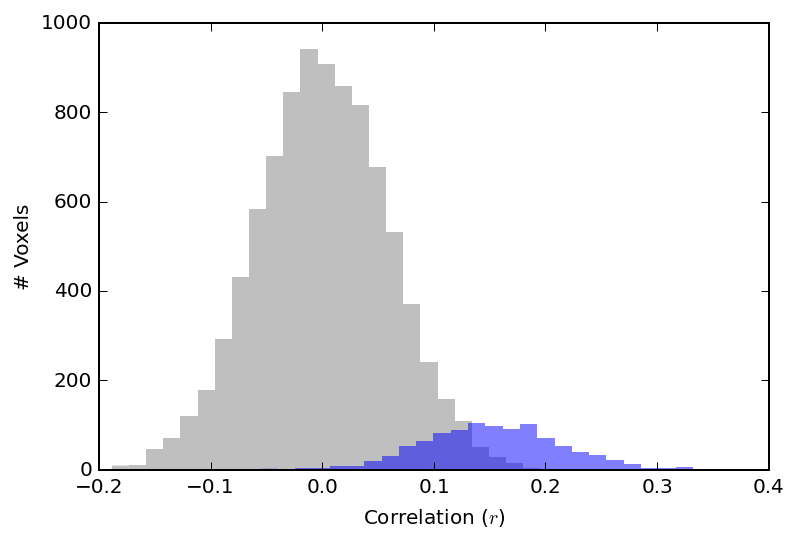

In [92]:
hist(corr[Mreal:], 25, ec='none', fc='0.5', alpha=0.5); # voxels that don't care for stimulus in gray
hist(corr[:Mreal], 25, ec='none', fc='b', alpha=0.5); # voxels that do care in blue
xlabel("Correlation ($r$)")
ylabel("# Voxels");

# Evaluate significance of prediction performance

In [93]:
from model_significance import exact_correlation_pvalue, correlation_pvalue

## Method 1: Exact test (assumes Gaussianity)
When two Gaussian random variables have zero covariance, the distribution of their sample correlation coefficient, $r$, is given by [\[ref\]](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#Use_the_exact_distribution):
$$f(r) = \frac{(1-r^2)^{\frac{n-4}{2}}}{B(\frac{1}{2},\frac{n-2}{2})}$$
where $B$ is the beta function and $n$ is the number of samples.

To compute a p-value we find the probability of finding a correlation at least as high as our observed correlation, $\hat{r}$, given the null distribution: 
$$P(r \ge \hat{r}) = \int_\hat{r}^1 f(r) dr$$

In [79]:
exact_pvals = np.array([exact_correlation_pvalue(c, T*(1-trnfrac)) for c in corr])

## Methods 2 & 3: Bootstrap and parametric bootstrap
For this bootstrap test we compute an empirical bootstrap distribution for $r$ by resampling across time. In the ordinary bootstrap we compute the p-value by finding the fraction of bootstrap samples for which $r<0$. Thus the smallest p-value that can be obtained with the ordinary bootstrap test is $\frac{1}{n_B}$, where $n_B$ is the number of bootstrap samples. 

In the parametric bootstrap we approximate the Fisher transform of the bootstrap distribution using a Gaussian distribution. Then we compute the p-value as the integral of the Gaussian mass below zero.

In [80]:
bs_pvals, bs_conf, pbs_pvals, pbs_conf, bscorrs = zip(*[correlation_pvalue(a, b, nboot=1000) 
                                                        for a,b in zip(Yp.T, Yp_est.T)])

## Method 4: Jackknife
For the jackknife test we split the data by time into chunks of length 10, then compute the correlation with each chunk withheld. These correlations are bias-corrected using the standard jackknife formula. Then we compute the standard error of the mean (SEM) of the unbiased correlations across the jackknife samples, figure out how many SEMs we need to get the desired level of significance, and check whether each voxel passes that threshold.

In [104]:
def jackknife_test(Yp_est, Yp, corr, desired_pval=0.01, split_length=10):
    j = int(Yp.shape[0] / split_length) # number of jackknife samples
    print "Doing %d jackknife samples of length 10" % j

    est_splits = np.vsplit(Yp_est, j)
    real_splits = np.vsplit(Yp, j)

    def jk_iter(lst):
        for ho in range(len(lst)):
            yield [lst[ii] for ii in range(len(lst)) if not ho==ii]

    # Compute correlations leaving out each jackknife set
    jk_corrs = [mcorr(np.vstack(a), np.vstack(b)) for a,b in zip(jk_iter(est_splits), jk_iter(real_splits))]

    # Compute unbiased estimate of jackknife correlation 
    unbiased_jk_corrs = [j*corr - (j - 1) * jc for jc in jk_corrs]

    # Compute standard error of the mean for each set of unbiased jackknife correlations
    jk_sems = np.vstack(unbiased_jk_corrs).std(0) / np.sqrt(j)

    # Figure out how many SEMs away from zero we need to get desired p-value
    # divide by two because two-sided?
    num_sems = scipy.stats.norm.ppf(1 - desired_pval / 2)
    print "SEMs:", num_sems

    # Compute jackknife significance
    jk_signif = (corr - num_sems * jk_sems) > 0
    
    return jk_signif

jk_signif = jackknife_test(Yp_est, Yp, corr, desired_pval=0.01, split_length=10)

Doing 29 jackknife samples of length 10
SEMs: 2.57582930355


## Plot some things

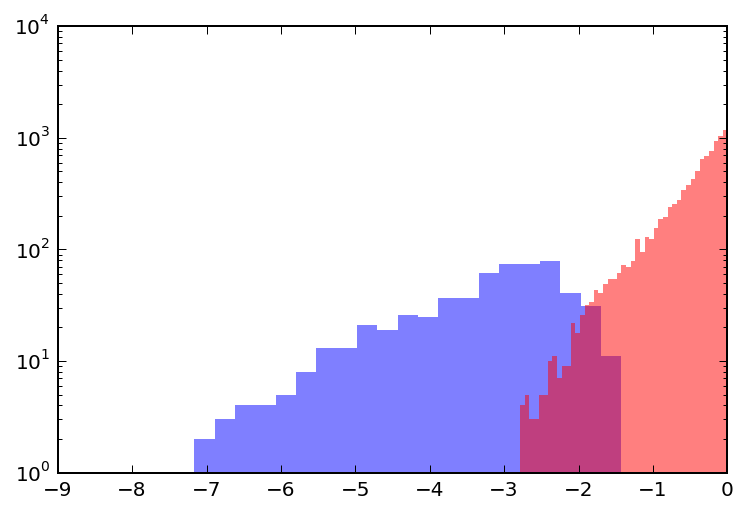

In [82]:
hist(np.log10(exact_pvals[jk_signif]), 25, ec='none', fc='blue', alpha=0.5, log=True);
hist(np.log10(exact_pvals[~jk_signif]), 50, ec='none', fc='red', alpha=0.5);

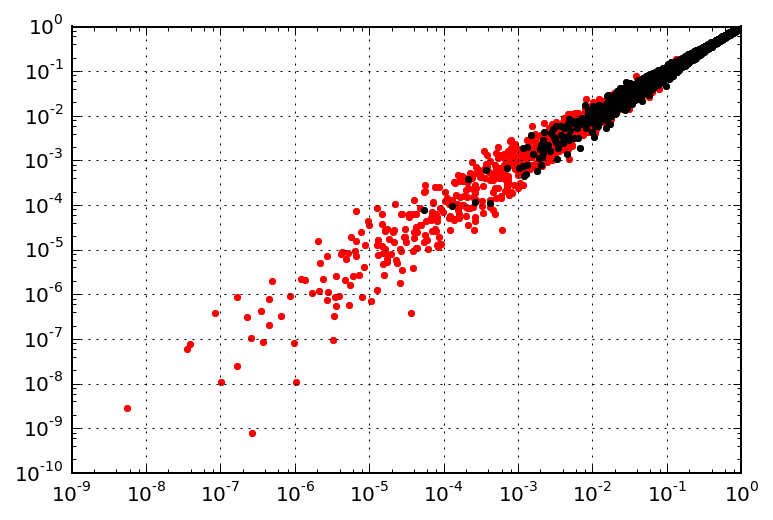

In [83]:
loglog(exact_pvals[:Mreal], pbs_pvals[:Mreal], 'r.')
loglog(exact_pvals[Mreal:], pbs_pvals[Mreal:], 'k.')
grid();

# Compute power, FDR, and true p-value for each method
To compare the 4 methods for computing p-values (or significance) I'm computing three metrics: 
* power (i.e. the fraction of responsive voxels that are labeled significant), 
* false discovery rate (FDR; i.e. the fraction of significant voxels that are non-responsive), 
* and, as a sanity check, the actual p-value (i.e. the fraction of non-responsive voxels that are labeled significant).

In [85]:
p = 0.01 # desired p-value

# assign significance for methods 1-3 (jackknife done above)
exact_signif = np.array(exact_pvals) < p
pbs_signif = np.array(pbs_pvals) < p
bs_signif = np.array(bs_pvals) < p

# define functions for computing power, FDR, and true p-value
power = lambda sg: sg[:Mreal].mean()
fdr = lambda sg: sg[Mreal:].sum() / sg.sum().astype(float)
truep = lambda sg: sg[Mreal:].mean()

# compute metrics for each method
exact_power = power(exact_signif)
exact_fdr = fdr(exact_signif)
exact_truep = truep(exact_signif)

bs_power = power(bs_signif)
bs_fdr = fdr(bs_signif)
bs_truep = truep(bs_signif)

pbs_power = power(pbs_signif)
pbs_fdr = fdr(pbs_signif)
pbs_truep = truep(pbs_signif)

jk_power = power(jk_signif)
jk_fdr = fdr(jk_signif)
jk_truep = truep(jk_signif)

In [86]:
print "Power:"
print "  Exact:", exact_power
print "  Bootstrap:", bs_power
print "  Par. bootstrap:", pbs_power
print "  Jackknife:", jk_power

Power:
  Exact: 0.562
  Bootstrap: 0.559
  Par. bootstrap: 0.568
  Jackknife: 0.512


In [87]:
print "FDR:"
print "  Exact:", exact_fdr
print "  Bootstrap:", bs_fdr
print "  Par. bootstrap:", pbs_fdr
print "  Jackknife:", jk_fdr

FDR:
  Exact: 0.135384615385
  Bootstrap: 0.146564885496
  Par. bootstrap: 0.154761904762
  Jackknife: 0.135135135135


In [97]:
print "True p-value:"
print "  Exact:", exact_truep
print "  Bootstrap:", bs_truep
print "  Par. bootstrap:", pbs_truep
print "  Jackknife:", jk_truep

# How unexpected are the differences between the desired p-value and true p-value?
print ""
print "p-value for difference between true and desired p-value:"
print "  Exact:", scipy.stats.binom_test(exact_signif[Mreal:].sum(), M - Mreal, p)
print "  PBS:", scipy.stats.binom_test(pbs_signif[Mreal:].sum(), M - Mreal, p)
print "  BS:", scipy.stats.binom_test(bs_signif[Mreal:].sum(), M - Mreal, p)
print "  Jackknife:", scipy.stats.binom_test(jk_signif[Mreal:].sum(), M - Mreal, p)

True p-value:
  Exact: 0.00977777777778
  Bootstrap: 0.0106666666667
  Par. bootstrap: 0.0115555555556
  Jackknife: 0.00888888888889

p-value for difference between true and desired p-value:
  Exact: 0.873793926183
  PBS: 0.137843841196
  BS: 0.524627603113
  Jackknife: 0.633631303124


Here it seems like the exact test and two bootstrap-based tests have better power than the jackknife test, and the exact and jackknife tests have better FDR than the bootstrap-based tests. But it's unclear how real those differences are.

Testing the bootstrap is expensive, but the exact and jackknife tests are easy. Let's run them a few times and see how repeatable these results are.

In [106]:
reps = 10
p = 0.01

exact_powers = []
exact_fdrs = []
jk_powers = []
jk_fdrs = []

for rep in range(reps):
    beta_real, X, Y, Xr, Xp, Yr, Yp = generate_data(T, N, M, Mfrac, noise_sd, beta_sd, trnfrac)
    beta_est, Yp_est, corr = fit_and_test_model(Xr, Yr, Xp, Yp)
    
    exact_signif = np.array([exact_correlation_pvalue(c, T*(1-trnfrac)) for c in corr]) < p
    jk_signif = jackknife_test(Yp_est, Yp, corr, desired_pval=p, split_length=10)
    
    exact_powers.append(power(exact_signif))
    exact_fdrs.append(fdr(exact_signif))
    
    jk_powers.append(power(jk_signif))
    jk_fdrs.append(fdr(jk_signif))


Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355
Doing 29 jackknife samples of length 10
SEMs: 2.57582930355


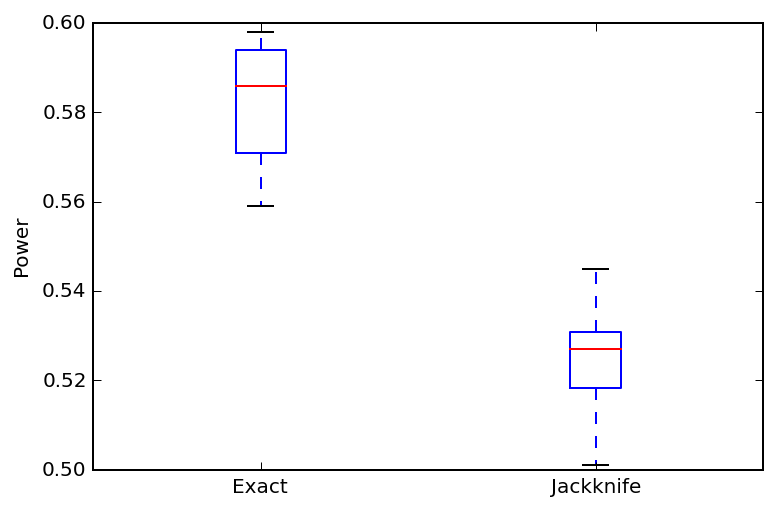

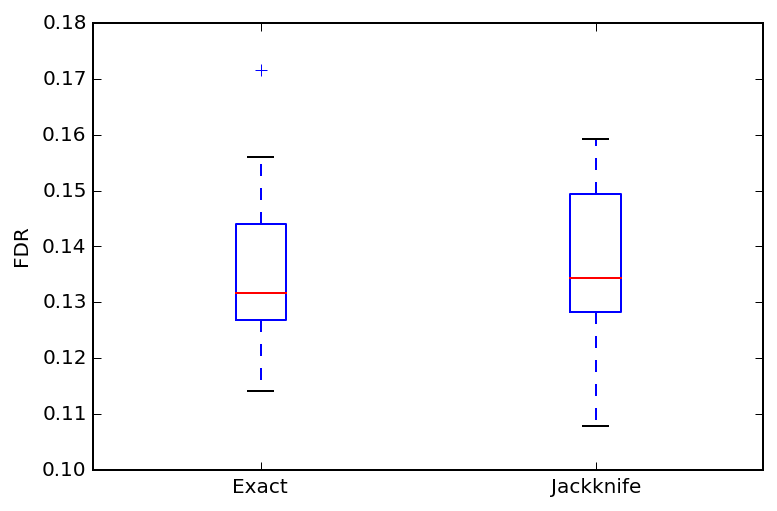

In [111]:
boxplot([exact_powers, jk_powers], labels=["Exact", "Jackknife"]);
ylabel("Power");

figure()
boxplot([exact_fdrs, jk_fdrs], labels=["Exact", "Jackknife"]);
ylabel("FDR");

### Just for fun: confirm beta-based null distribution on bivariate correlation

In [263]:
import scipy.special
import scipy

fnull = lambda r,n: (1-r**2)**((n-4.0)/2.0)/scipy.special.beta(0.5, (n-2)/2.0)

n = 100
m = 100000
null_corrs = np.array([np.corrcoef(np.random.randn(n), np.random.randn(n))[0,1] for _ in range(m)])

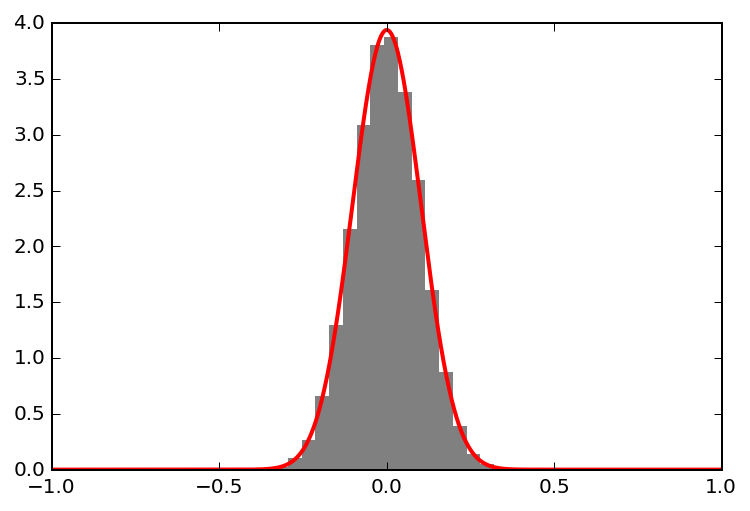

In [265]:
r = np.linspace(-1, 1, 1000)
null_pdf = fnull(r, n)

hist(null_corrs, 20, normed=True, ec='none', fc='0.5')
plot(r, null_pdf, 'r', lw=2)